In [30]:
import numpy as np
import torch
from torch.autograd import Variable
import os
import sys
import matplotlib.pyplot as plt

In [31]:
path_to_pydeformetrica = '/Users/maxime.louis/Documents/pydeformetrica'
sys.path.append(os.path.join(path_to_pydeformetrica, '../'))
from pydeformetrica.src.in_out.xml_parameters import XmlParameters
from pydeformetrica.src.in_out.dataset_functions import create_template_metadata
from pydeformetrica.src.in_out.deformable_object_reader import DeformableObjectReader
from pydeformetrica.src.core.model_tools.attachments.multi_object_attachment import MultiObjectAttachment
from pydeformetrica.src.support.kernels.kernel_functions import create_kernel
from pydeformetrica.src.support.utilities.general_settings import Settings
from src.in_out.array_readers_and_writers import *

In [37]:
path_experiments = '/Users/maxime.louis/Documents/metric_learning/synthetic_image'

#suffix = '_no_averaging_'
#suffix = '_'
#suffix = '_time_estimation_'

#noise_level = 0.025
#noise_level = 0.05
noise_level = 0.075
suffix = '_v2__' + str(noise_level) + '_'
path_synthetic =[os.path.join(path_experiments, 'synthetic_dataset' + suffix + str(experiment_number)) for experiment_number in range(10)]
                             
path_to_output = [os.path.join(elt, 'output') for elt in path_synthetic]
path_to_test_registration = [os.path.join(elt, 'registration_test') for elt in path_synthetic]
path_to_train_registration = [os.path.join(elt, 'registration_train') for elt in path_synthetic]
optimization_parameters_xml_path = os.path.join(path_experiments, 'optimization_parameters.xml')
train_model_name = 'LongitudinalMetricModel'
test_model_name = 'LongitudinalRegistration'

fold_to_plot = 8

initialized_model_xml_path = os.path.join(path_synthetic[fold_to_plot], 'model_after_initialization.xml')


dataset_xml_train_path = [os.path.join(elt, 'data_set_train.xml') for i,elt in enumerate(path_synthetic)]
dataset_xml_test_path = [os.path.join(elt, 'data_set_test.xml') for i,elt in enumerate(path_synthetic)]
#dataset_xml_path = os.path.join(path_to_atlas, 'data_set.xml')

xml_parameters_train = XmlParameters()
xml_parameters_train.read_all_xmls(initialized_model_xml_path, dataset_xml_train_path[fold_to_plot], optimization_parameters_xml_path)

xml_parameters_test = XmlParameters()
xml_parameters_test.read_all_xmls(initialized_model_xml_path, dataset_xml_test_path[fold_to_plot], optimization_parameters_xml_path)

>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p


In [38]:
def load_images(l):
    return [np.load(elt) for elt in l]

def load_subject_images_from_data_set(i, xml_parameters):
    for key in  xml_parameters.template_specifications.keys():
        object_name = key
        break
    subject_filenames = [elt[object_name] for elt in xml_parameters.dataset_filenames[i]]
    return load_images([os.path.join(path_synthetic[fold_to_plot], elt) for elt in subject_filenames])

def load_reconstructed_images(i):
    subject_folder = os.path.join(path_to_output[fold_to_plot], 'subject_'+str(i))
    paths = [elt for elt in os.listdir(subject_folder) if elt.find('.npy')>0]
    sorted_paths = sorted(paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    return load_images([os.path.join(subject_folder, elt) for elt in sorted_paths])

In [5]:
trajectories_parameters = []
for i in range(10):
    path_to_trajectory = os.path.join(path_to_output[i], train_model_name + '__EstimatedParameters__Trajectory.npy')
    trajectories_parameters.append(np.load(path_to_trajectory)[()])
for key, val in trajectories_parameters[fold_to_plot].items():
    print(key, val.shape)

p0 (301, 3)
reference_time (301, 1)
v0 (301, 3)
onset_age_variance (301, 1)
log_acceleration_variance (301, 1)
noise_variance (301, 1)
modulation_matrix (301, 6)
metric_parameters (301, 4313)


# 1. Print parameters trajectory


Final noise variance: 0.0808469273248
Final noise variance: 0.0849160613564
Final noise variance: 0.0793007781721
Final noise variance: 0.0815411582707
Final noise variance: 0.081738572716
Final noise variance: 0.0799568728097
Final noise variance: 0.079021429723
Final noise variance: 0.0789909695969
Final noise variance: 0.0810789789667
Final noise variance: 0.0800850146629
Final noises: 0.0807476763599 +/- 0.00168316624343


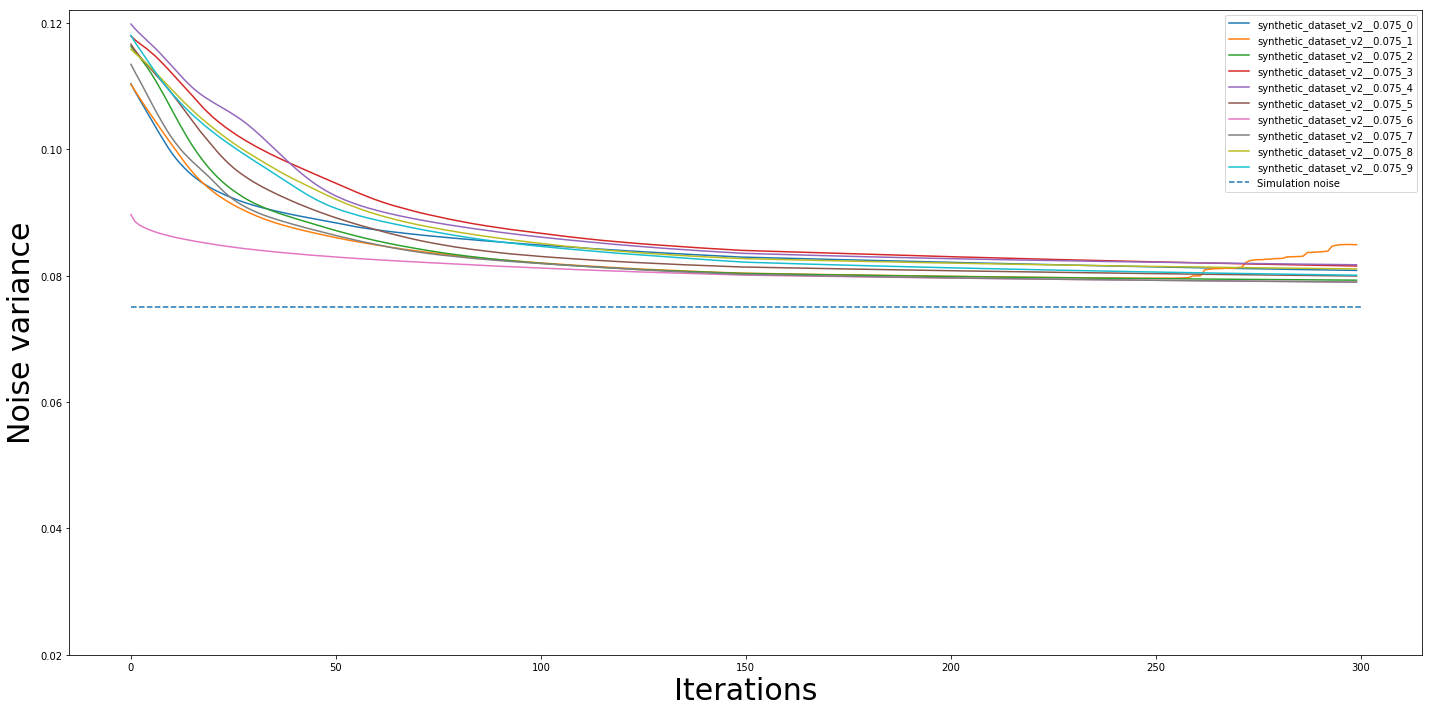

In [6]:
# noise variance 
final_noises = []
plt.figure(figsize=(20,10))
for i in range(10):
    noise_variances = np.sqrt(trajectories_parameters[i]['noise_variance'][1:])
    #print(noise_variances)
    print("Final noise variance:", noise_variances[-1][0])
    final_noises.append(noise_variances[-1][0])
    plt.plot(noise_variances, label=os.path.basename(path_synthetic[i]))
plt.ylabel("Noise variance", fontsize=30)
plt.xlabel("Iterations", fontsize=30)
plt.plot([0., 300.],[noise_level, noise_level], label='Simulation noise', linestyle='dashed')
print('Final noises:', np.mean(final_noises),'+/-',np.std(final_noises))
plt.ylim(0.02)
#plt.xlim(0,300)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_experiments, 'figures','Noise_recovery'+suffix+'.pdf'), bbox_inches=0)
plt.show()

# reference time and onset age variance
#reference_times = trajectory_all_parameters['reference_time']
#print(noise_variances)
#print("Final reference time:", noise_variances[-1][0])
#plt.plot(reference_times)
#plt.ylabel("Reference time")
#plt.xlabel("Iterations")
#plt.legend()
#plt.show()

>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel wid

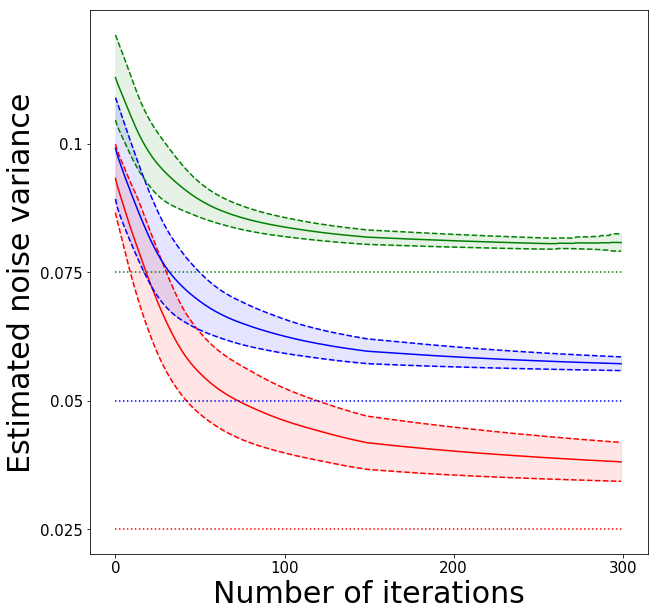

In [7]:
noise_levels = [0.025, 0.05, 0.075]
noise_variances_mean = []
noise_variances_std = []
for n in noise_levels:
    suffix = '_v2__' + str(n) + '_'
    path_synthetic =[os.path.join(path_experiments, 'synthetic_dataset' + suffix + str(experiment_number)) for experiment_number in range(10)]

    path_to_output = [os.path.join(elt, 'output') for elt in path_synthetic]
    path_to_test_registration = [os.path.join(elt, 'registration_test') for elt in path_synthetic]
    path_to_train_registration = [os.path.join(elt, 'registration_train') for elt in path_synthetic]
    optimization_parameters_xml_path = os.path.join(path_experiments, 'optimization_parameters.xml')
    train_model_name = 'LongitudinalMetricModel'
    test_model_name = 'LongitudinalRegistration'

    fold_to_plot = 0

    initialized_model_xml_path = os.path.join(path_synthetic[fold_to_plot], 'model_after_initialization.xml')


    dataset_xml_train_path = [os.path.join(elt, 'data_set_train.xml') for i,elt in enumerate(path_synthetic)]
    dataset_xml_test_path = [os.path.join(elt, 'data_set_test.xml') for i,elt in enumerate(path_synthetic)]
    #dataset_xml_path = os.path.join(path_to_atlas, 'data_set.xml')

    xml_parameters_train = XmlParameters()
    xml_parameters_train.read_all_xmls(initialized_model_xml_path, dataset_xml_train_path[fold_to_plot], optimization_parameters_xml_path)

    xml_parameters_test = XmlParameters()
    xml_parameters_test.read_all_xmls(initialized_model_xml_path, dataset_xml_test_path[fold_to_plot], optimization_parameters_xml_path)
    trajectories_parameters = []
    
    noise_variances_for_noise = []
    for i in range(10):
        path_to_trajectory = os.path.join(path_to_output[i], train_model_name + '__EstimatedParameters__Trajectory.npy')
        trajectories_parameters.append(np.load(path_to_trajectory)[()])
        noise_variances_for_noise.append(np.sqrt(trajectories_parameters[i]['noise_variance'][1:]).flatten())
        
    noise_variances_for_noise = np.array(noise_variances_for_noise)
    noise_variances_mean.append(np.mean(noise_variances_for_noise, axis=0))
    noise_variances_std.append(np.std(noise_variances_for_noise, axis=0))
    #print(noise_variances_for_noise.shape, np.array(noise_variances_mean).shape, np.array(noise_variances_std).shape)

plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'green']
for i, n in enumerate(noise_levels):
    #print(noise_variances_mean)
    plt.plot(noise_variances_mean[i], c=colors[i])
    plus_std = noise_variances_mean[i] + noise_variances_std[i]
    plt.plot(plus_std, c=colors[i], linestyle='dashed')
    minus_std = noise_variances_mean[i] - noise_variances_std[i]
    plt.plot(minus_std, c=colors[i], linestyle='dashed')
    plt.fill_between(range(len(plus_std)), minus_std, plus_std, color=colors[i], alpha='0.1')
    plt.plot([0., 300.],[n, n], c=colors[i], linestyle='dotted')

plt.xlabel('Number of iterations', fontsize=30)
plt.ylabel('Estimated noise variance', fontsize=30)
plt.xticks([0, 100, 200, 300], ['0','100','200','300'])
plt.yticks([0.025, 0.05, 0.075, 0.1], ['0.025', '0.05', '0.075', '0.1'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(os.path.join('/Users/maxime.louis/Documents/metric_learning/synthetic_image/figures', 'Noise_variance_estimation.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()
    

# 3 Absolute times

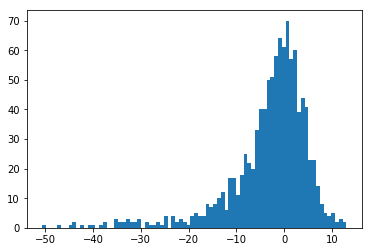

In [91]:
# Absolute times Plotting the histogram for the last observation
abs_times = np.loadtxt(os.path.join(path_to_output[fold_to_plot], train_model_name + "_absolute_times.txt"))
plt.hist(abs_times, bins=80)
plt.show()

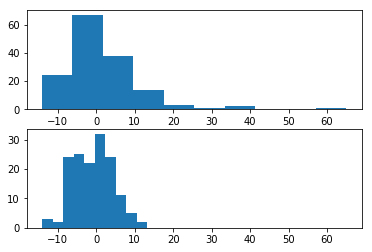

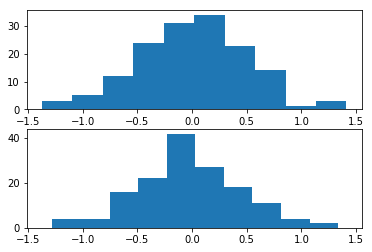

In [92]:
# Last realisations for the alphas and onset ages
log_accelerations = np.loadtxt(os.path.join(path_to_output[fold_to_plot], train_model_name + "_log_accelerations.txt"))
onset_ages = np.loadtxt(os.path.join(path_to_output[fold_to_plot], train_model_name + "_onset_ages.txt"))
info = np.loadtxt('/Users/maxime.louis/Documents/metric_learning/synthetic_image/info_subjects' +
                  suffix + str(fold_to_plot)) [:150, :]
log_accelerations_truth = np.log(info[:,0])[:150]
onset_ages_truth = info[:,1][:150]

ax1 = plt.subplot(211)
plt.hist(onset_ages, bins=10)
plt.xlabel(' onset ages distribution')
ax2 = plt.subplot(212, sharex=ax1)
plt.hist(onset_ages_truth, bins=10)
plt.show()

ax1 = plt.subplot(211)
plt.hist(log_accelerations, bins=10)
ax2 = plt.subplot(212, sharex=ax1)
plt.hist(log_accelerations_truth, bins=10)
plt.show()



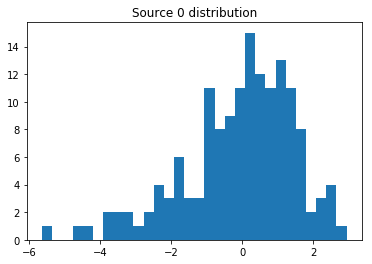

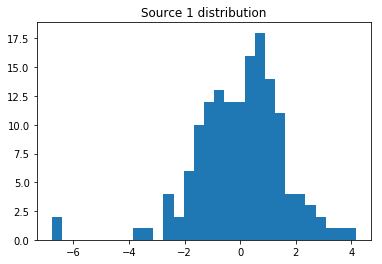

(2, 150) (3, 150)


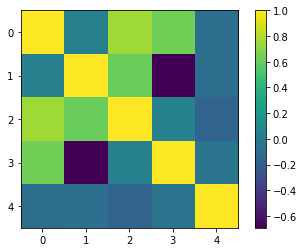

In [93]:
sources = np.loadtxt(os.path.join(path_to_output[fold_to_plot], train_model_name + "_sources.txt"))
if len(sources.shape) == 1:
    sources = sources.reshape(len(sources), 1)
number_of_sources = len(sources[0])
for i in range(len(sources[0])):
    plt.hist(sources[:, i], bins=30)
    plt.title("Source "+str(i)+" distribution")
    plt.show()
    
    
real_info = info[:,2:5]
print(sources.T.shape, real_info.T.shape)
corr_matrix = np.corrcoef(sources.T, real_info.T)
plt.imshow(corr_matrix)
plt.colorbar()
plt.show()

In [12]:
log_acceleration_error = np.mean(np.abs(log_accelerations-log_accelerations_truth))
print("Log acceleration avg error on train:", log_acceleration_error)

onset_ages_error = np.mean(np.abs(onset_ages-onset_ages_truth))
print("Onset ages avg error on train:", onset_ages_error)

plt.plot([np.min(onset_ages),np.max(onset_ages)],[np.min(onset_ages),np.max(onset_ages)])
plt.scatter(onset_ages, onset_ages_truth)
plt.show()

plt.plot([np.min(log_accelerations), np.max(log_accelerations)],[np.min(log_accelerations), np.max(log_accelerations)])
plt.scatter(log_accelerations, log_accelerations_truth)
plt.show()
print(sources.shape)
corr_matrix = np.corrcoef([log_accelerations, onset_ages, sources[:,0], sources[:,1], log_accelerations_truth, onset_ages_truth])
plt.imshow(corr_matrix)
plt.xlabel('x_i, tau_i, xi_truth, tau_i_truth')
plt.colorbar()
plt.show()

NameError: name 'log_accelerations' is not defined

Log acceleration avg error on test: 0.481070306582
Onset ages avg error on test: 4.58943790278


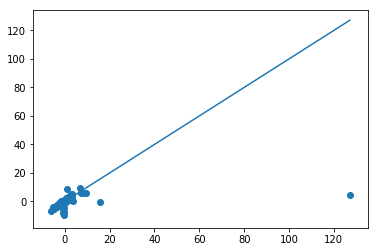

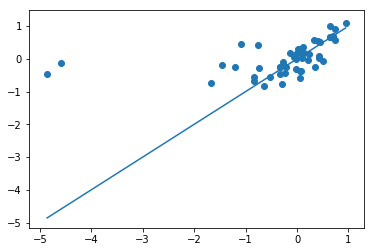

Train residuals: 0.0415180651344 +/- 0.00563291544736
Test residuals 0.2060436 +/- 0.0122143702678
Train residuals registration 0.206046306667 +/- 0.011153963124


In [46]:
# We also want test set onset ages an alphas as well as residuals.
test_onset_ages = np.loadtxt(os.path.join(path_to_test_registration[fold_to_plot], 'LongitudinalRegistration_onset_ages.txt'))
test_log_accelerations = np.loadtxt(os.path.join(path_to_test_registration[fold_to_plot], 'LongitudinalRegistration_log_accelerations.txt'))
info_test = np.loadtxt('/Users/maxime.louis/Documents/metric_learning/synthetic_image/info_subjects'+suffix+
                  str(fold_to_plot))[150:, :]
test_log_accelerations_truth = np.log(info_test[:, 0])
test_onset_ages_truth = info_test[:,1]
                                    
test_log_acceleration_error = np.mean(np.abs(test_log_accelerations-test_log_accelerations_truth))
print("Log acceleration avg error on test:", test_log_acceleration_error)

test_onset_ages_error = np.mean(np.abs(test_onset_ages-test_onset_ages_truth))
print("Onset ages avg error on test:", test_onset_ages_error)

plt.plot([np.min(test_onset_ages),np.max(test_onset_ages)],[np.min(test_onset_ages),np.max(test_onset_ages)])
plt.scatter(test_onset_ages, test_onset_ages_truth)
plt.show()

plt.plot([np.min(test_log_accelerations), np.max(test_log_accelerations)],[np.min(test_log_accelerations), np.max(test_log_accelerations)])
plt.scatter(test_log_accelerations, test_log_accelerations_truth)
plt.show()

# Noise level
train_residuals = np.loadtxt(os.path.join(path_to_output[fold_to_plot], train_model_name + '_residuals.txt'))
train_residuals_registration = np.loadtxt(os.path.join(path_to_train_registration[fold_to_plot], test_model_name + '_residuals.txt'))
test_residuals = np.loadtxt(os.path.join(path_to_test_registration[0], test_model_name + '_residuals.txt'))
print('Train residuals:', np.mean(train_residuals**2), '+/-', np.std(train_residuals))
print('Test residuals', np.mean(test_residuals), '+/-', np.std(test_residuals))
print('Train residuals registration', np.mean(train_residuals_registration), '+/-', np.std(train_residuals_registration))          
                
# We evaluate the same errors with the noise out of the target image.
def load_reconstructed_registration_train(i):
    subject_folder = os.path.join(path_to_train_registration[fold_to_plot], 'subject_'+str(i))
    paths = [elt for elt in os.listdir(subject_folder) if elt.find('.npy')>0]
    sorted_paths = sorted(paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    #print([os.path.join(subject_folder, elt) for elt in sorted_paths])
    return load_images([os.path.join(subject_folder, elt) for elt in sorted_paths])

def load_reconstructed_registration_test(i):
    subject_folder = os.path.join(path_to_test_registration[fold_to_plot], 'subject_'+str(i))
    paths = [elt for elt in os.listdir(subject_folder) if elt.find('.npy')>0]
    sorted_paths = sorted(paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    #print(sorted_paths)
    return load_images([os.path.join(subject_folder, elt) for elt in sorted_paths])



In [14]:
avg_train_no_noise = []
avg_train = []
avg_test_no_noise = []
avg_test = []

for fold_to_plot in range(10):
    noise = np.load(os.path.join(path_experiments,'noise'+ suffix + str(fold_to_plot)+'.npy'))
    # Getting the experimental noise variance
    noise_on_each_image = np.sum(np.sum(noise**2, axis=1), axis=1)
    noise_std = np.sqrt(np.mean(noise_on_each_image/(64*64)))
    print('Empirical noise std', noise_std)
    xml_parameters_train = XmlParameters()
    xml_parameters_train.read_all_xmls(initialized_model_xml_path, dataset_xml_train_path[fold_to_plot], optimization_parameters_xml_path)

    xml_parameters_test = XmlParameters()
    xml_parameters_test.read_all_xmls(initialized_model_xml_path, dataset_xml_test_path[fold_to_plot], optimization_parameters_xml_path)
    pos = 0
    train_residuals = []
    test_residuals = []
    train_residual_without_noise = []
    test_residual_without_noise = []
    for i in range(len(xml_parameters_train.dataset_filenames)):
        image_subject = np.array(load_subject_images_from_data_set(i, xml_parameters_train))
        image_subject_no_noise = np.zeros(image_subject.shape)
        reconstructed = np.array(load_reconstructed_registration_train(i))
        for j in range(len(image_subject)):
            image_subject_no_noise[j] = image_subject[j] - noise[pos]
            pos += 1
        residual_for_each_obs_no_noise = np.sqrt(np.sum(np.sum((image_subject_no_noise-reconstructed)**2, axis=1), axis=1)/(64*64))
        residuals_no_noise = np.mean(residual_for_each_obs_no_noise)
        train_residual_without_noise.append(residuals_no_noise)
        residual_for_each_obs = np.sqrt(np.sum(np.sum((image_subject-reconstructed)**2, axis=1), axis=1)/(64*64))
        residuals = np.mean(residual_for_each_obs)
        train_residuals.append(residuals)

    for i in range(len(xml_parameters_test.dataset_filenames)):
        image_subject = np.array(load_subject_images_from_data_set(i, xml_parameters_test))
        reconstructed = np.array(load_reconstructed_registration_test(i))
        image_subject_no_noise = np.zeros(image_subject.shape)
        for j in range(len(image_subject)):
            image_subject_no_noise[j] = image_subject[j] - noise[pos]
            pos += 1
        residual_for_each_obs_no_noise = np.sqrt(np.sum(np.sum((image_subject_no_noise-reconstructed)**2, axis=1), axis=1)/(64*64))
        residuals_no_noise = np.mean(residual_for_each_obs_no_noise)
        test_residual_without_noise.append(residuals_no_noise)
        residual_for_each_obs = np.sqrt(np.sum(np.sum((image_subject-reconstructed)**2, axis=1), axis=1)/(64*64))
        residuals = np.mean(residual_for_each_obs)
        test_residuals.append(residuals)
        
    avg_train.append(np.mean(train_residuals))
    avg_train_no_noise.append(np.mean(train_residual_without_noise))
    avg_test.append(np.mean(test_residuals))
    avg_test_no_noise.append(np.mean(test_residual_without_noise))

    print('Train residuals (with noise):', np.mean(train_residuals), '+/-', np.std(train_residuals))
    print('Test residuals (with noise):', np.mean(test_residuals), '+/-', np.std(test_residuals))
    print('Train residuals (without noise):', np.mean(train_residual_without_noise), '+/-', np.std(train_residual_without_noise))
    print('Test residuals (without noise):', np.mean(test_residual_without_noise), '+/-', np.std(test_residual_without_noise))

print('Averaged over all folds:')
print('Train residuals', np.mean(avg_train), '+/-', np.std(avg_train))
print('Train residuals (no noise)', np.mean(avg_train_no_noise), '+/-', np.std(avg_train_no_noise))
print('Train residuals', np.mean(avg_test), '+/-', np.std(avg_test))
print('Train residuals (no noise)', np.mean(avg_test_no_noise), '+/-', np.std(avg_test_no_noise))

Empirical noise std 0.0749893581718
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
Train residuals (with noise): 0.0848764994816 +/- 0.0147578265976
Test residuals (with noise): 0.083155740778 +/- 0.00884457526255
Train residuals (without noise): 0.0347246866557 +/- 0.0228215684337
Test residuals (without noise): 0.0323911545799 +/- 0.0159975171192
Empirical noise std 0.0749722434065
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has already been set [ in xml_parameters ]. Ignoring.
>> State will be saved in file output/pydef_state.p
>> No initial CP spacing given: using diffeo kernel width of 0
>> Warning: context has alread

# 3 Plotting some images


In [57]:
from PIL import Image
def load_images(l):
    return [np.load(elt) for elt in l]

def load_image_trajectory(folder):
    #image_paths = [elt for elt in os.listdir(folder) if elt.find('.png') >= 0]
    image_paths = [elt for elt in os.listdir(folder) if elt.find('.npy') >= 0]
    image_paths = sorted(image_paths, key=(lambda x: float(x[x.find('_t__')+4 : x.find('.npy')])))
    pad = int(len(image_paths)/4)
    image_paths = image_paths[pad:]
    image_paths = image_paths[:-pad]
    to_keep = 7
    image_paths_aux = []
    if len(image_paths) > to_keep:
        stride = int(len(image_paths)/to_keep)
        for i in range(to_keep):
            image_paths_aux.append(image_paths[i*stride])
        image_paths = image_paths_aux
    #print(image_paths)
    return load_images([os.path.join(folder, elt) for elt in image_paths])
    #return [np.array(Image.open(os.path.join(folder, elt)))/255 for elt in image_paths]
    
def plot_images(images, name=None):
    images = np.array(images)
    if len(images.shape)==3:
        images = images.reshape((1,)+images.shape)
    a,b,c,d = images.shape
    # We reshape to get a single image
    images = np.concatenate(np.concatenate(images, axis=1), axis=1)
    plt.figure(figsize=(10*b, 10*a), frameon=False)
    plt.tight_layout()
    plt.imshow(images, cmap='gray')
    plt.axis('off')
    #print(round(np.min(images), 2), round(np.max(images), 2))
    #ticks=[round(np.min(images), 2), round(np.max(images), 2)], 
    colorbar = plt.colorbar(shrink=0.3, orientation='horizontal', pad=0.02)
    colorbar.ax.tick_params(labelsize=30)
    if name is not None:
        if not os.path.isdir(os.path.join(path_experiments, 'figures')):
            os.mkdir(os.path.join(path_experiments, 'figures'))
        plt.savefig(os.path.join(path_experiments, 'figures', os.path.basename(path_synthetic[fold_to_plot]) + '_' + name), bbox_inches='tight', pad_inches=0)
    plt.show()
        


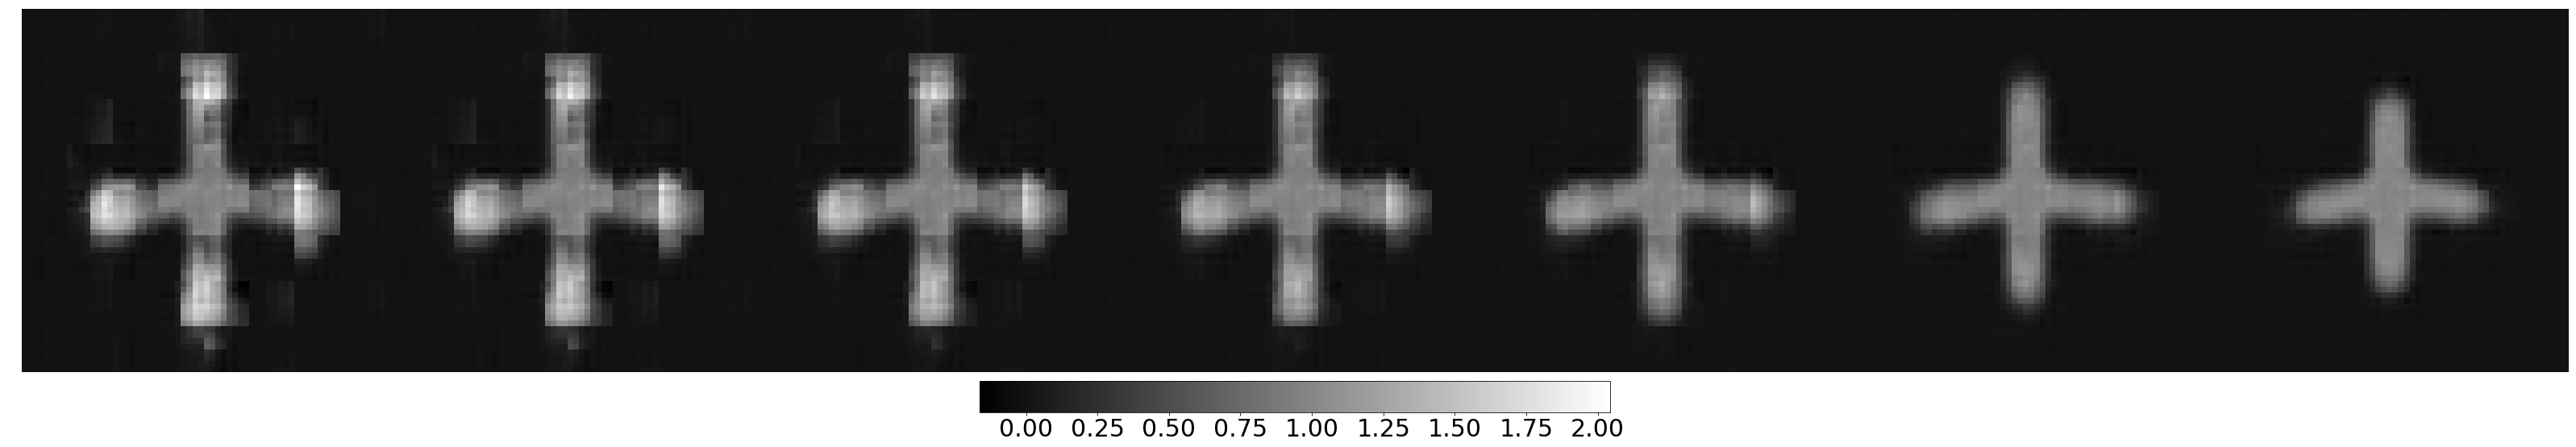

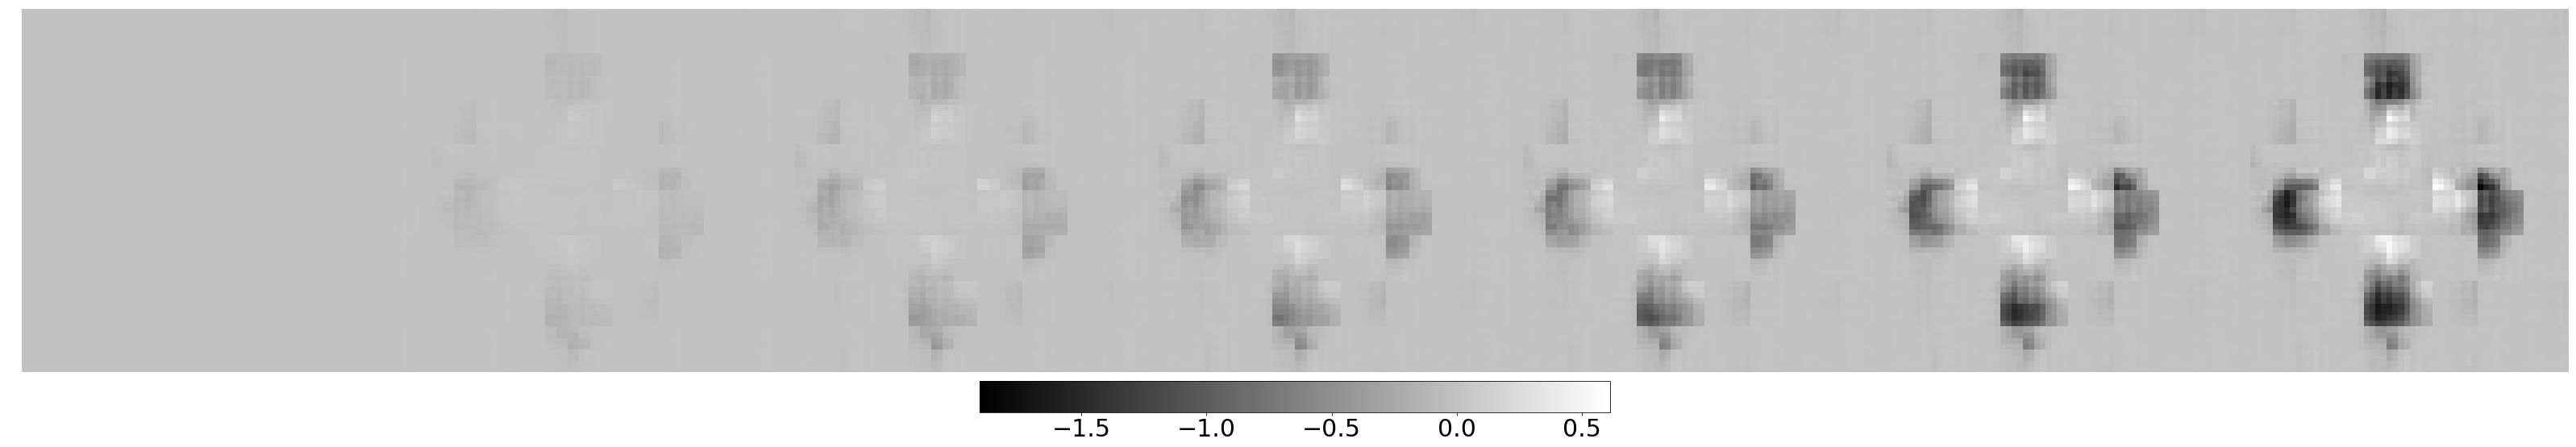

In [39]:
# Geodesic trajectory
geodesic_folder = os.path.join(path_to_output[fold_to_plot], 'geodesic_trajectory')
geodesic_images = load_image_trajectory(geodesic_folder)
plot_images(geodesic_images, name='reference_geodesic.pdf')

diff = [elt - geodesic_images[0] for elt in geodesic_images]
plot_images(diff, name='differences.pdf')

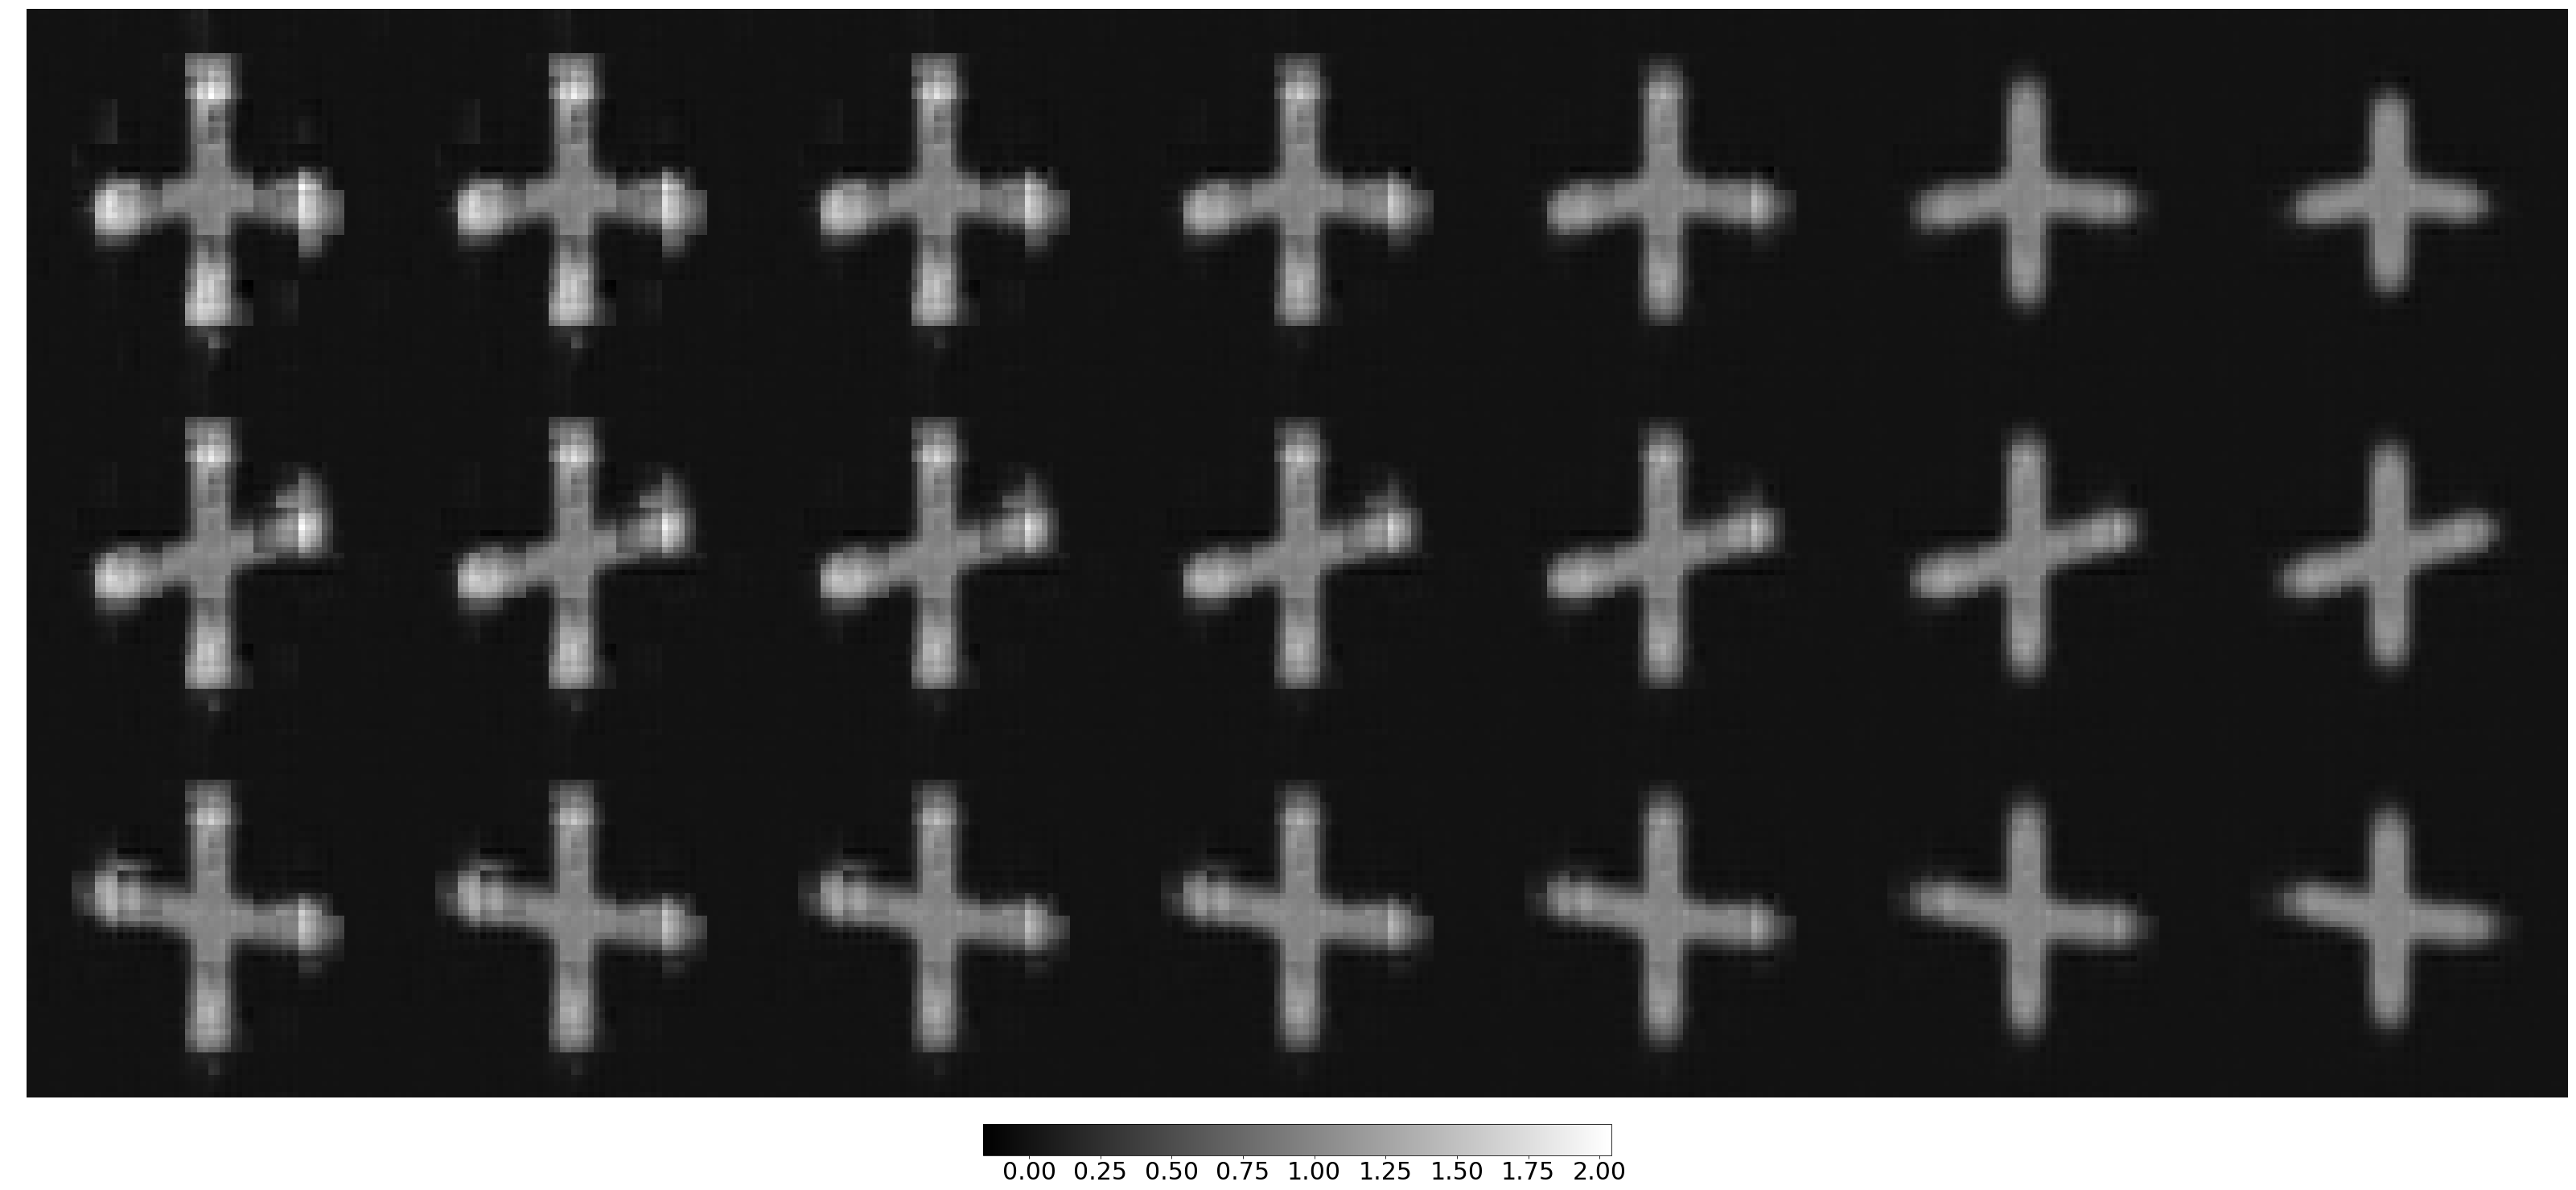

In [43]:
sources_traj = []
sources_traj.append(geodesic_images)
for i in range(2):
    source_folder = os.path.join(path_to_output[fold_to_plot], 'parallel_curve_neg_' + str(i))
    sources_traj.append(load_image_trajectory(source_folder))
plot_images(sources_traj, name='sources.pdf')

In [44]:
diff_sources_traj =[]
for i in range(min(number_of_sources, 10)):
    diff_sources_traj.append([sources_traj[i+1][j] - geodesic_images[j] for j in range(len(geodesic_images))])
plot_images(diff_sources_traj, name='sources_diff.pdf')

NameError: name 'number_of_sources' is not defined

Examples of train registrations:
-0.31106342954 1.23243811517 -0.133469 1.13038


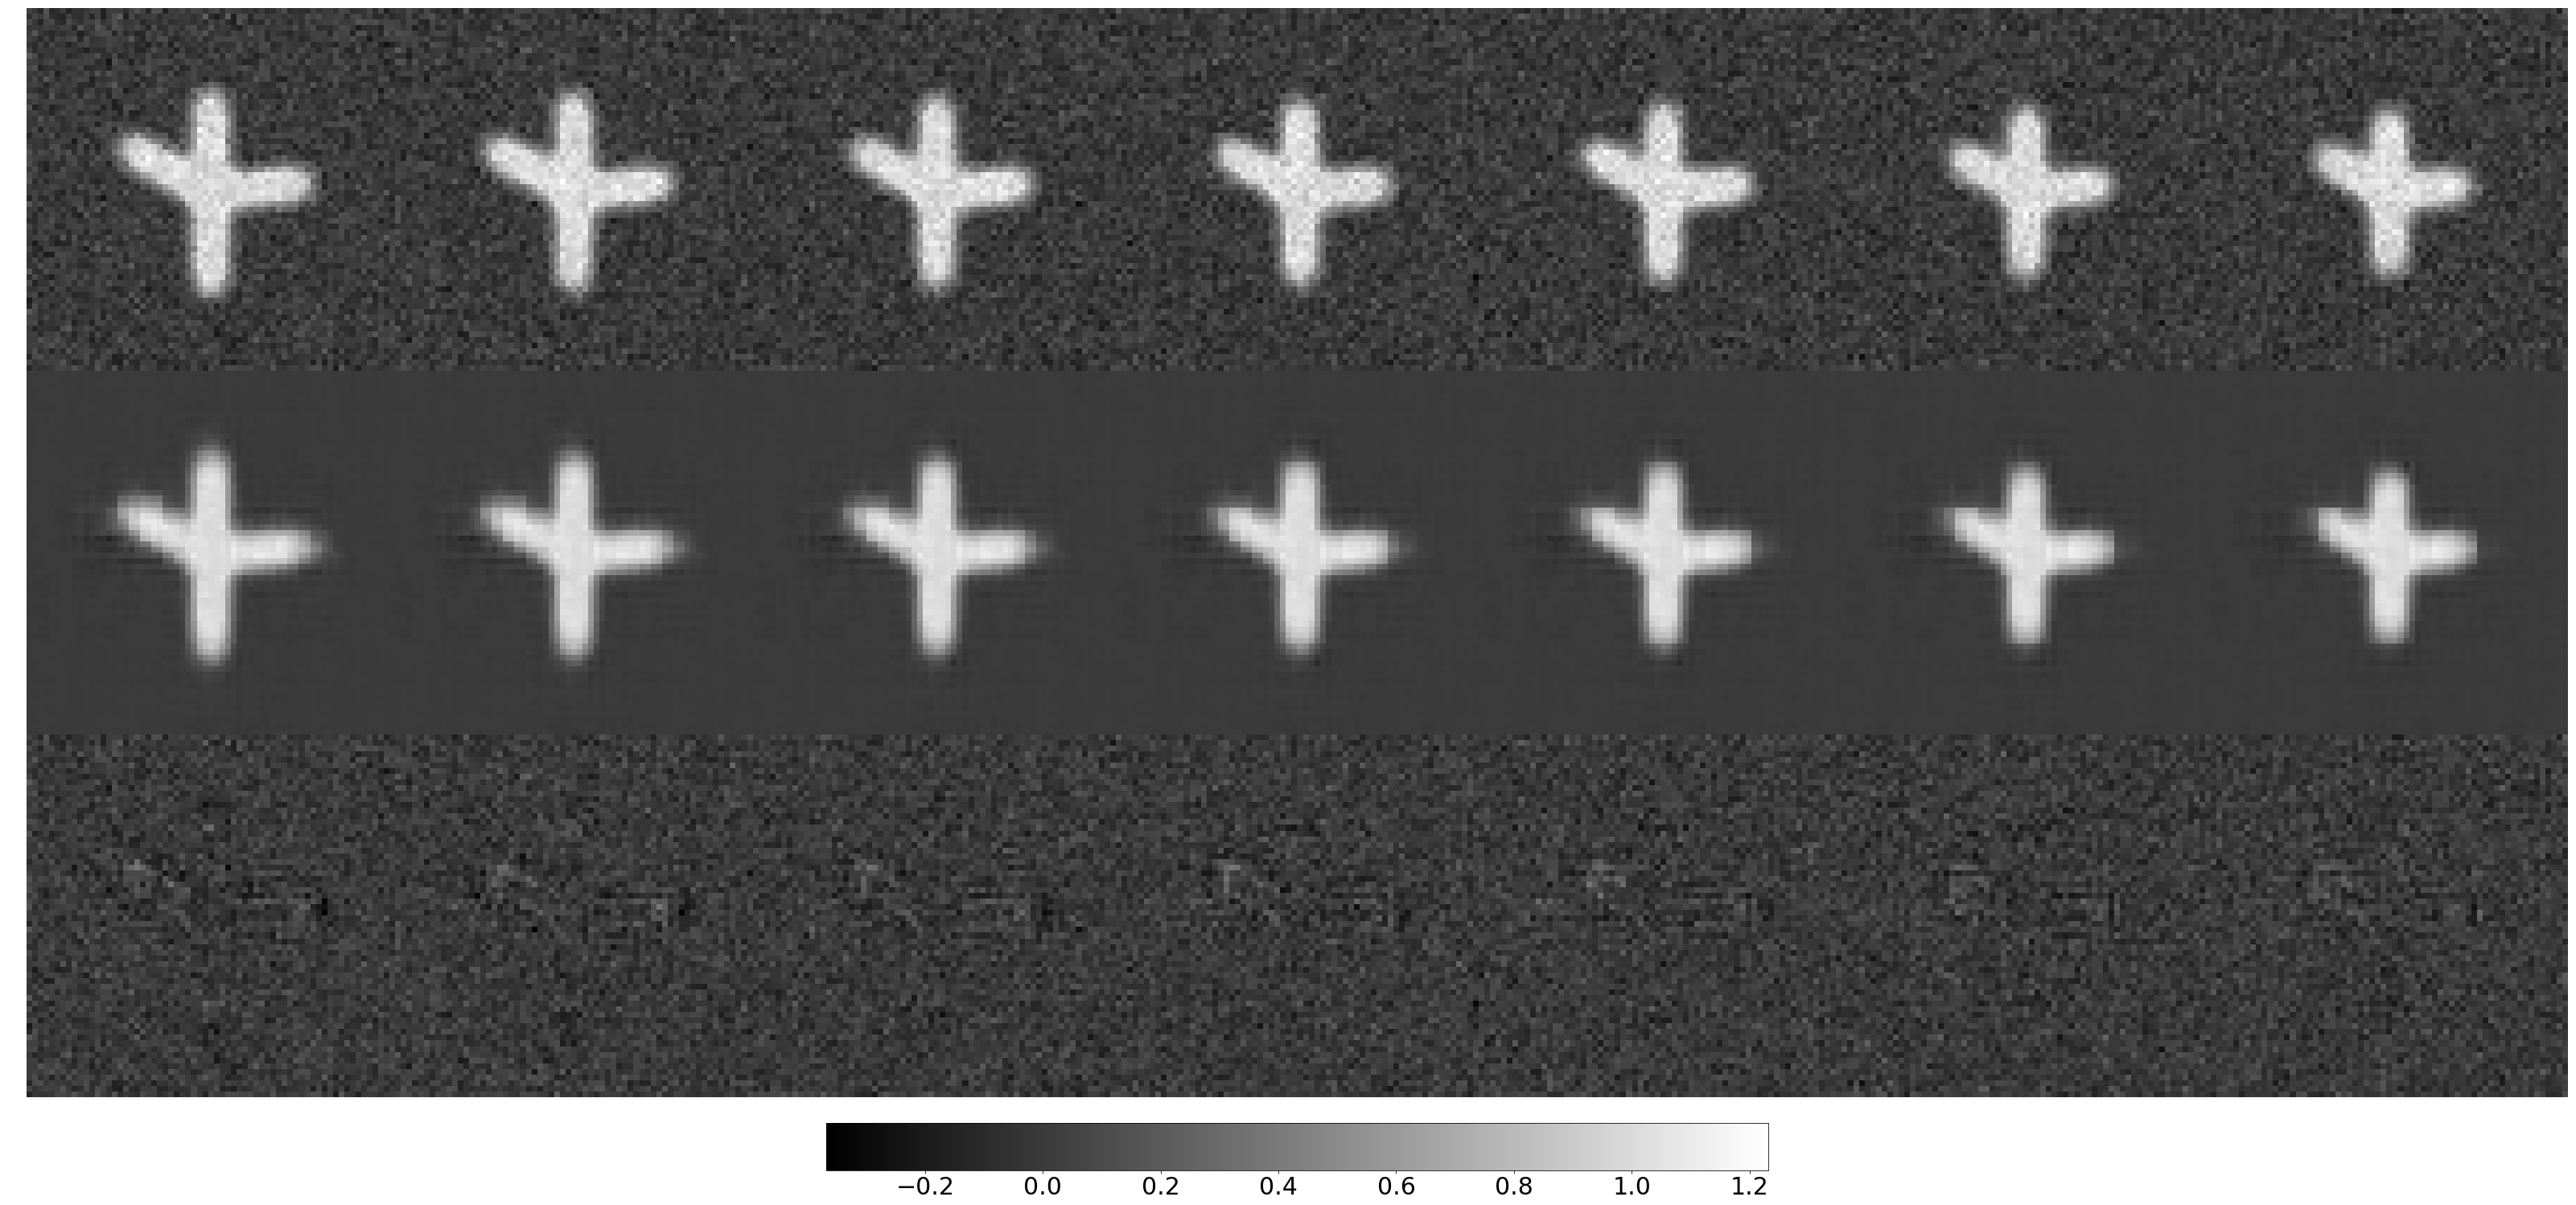

Examples of test registrations:
-0.326379557544 1.242546321 -0.199782 1.26652
-0.283392223161 1.24218865118 -0.190632 1.21977
-0.303158984713 1.32114987345 -0.189976 1.1398


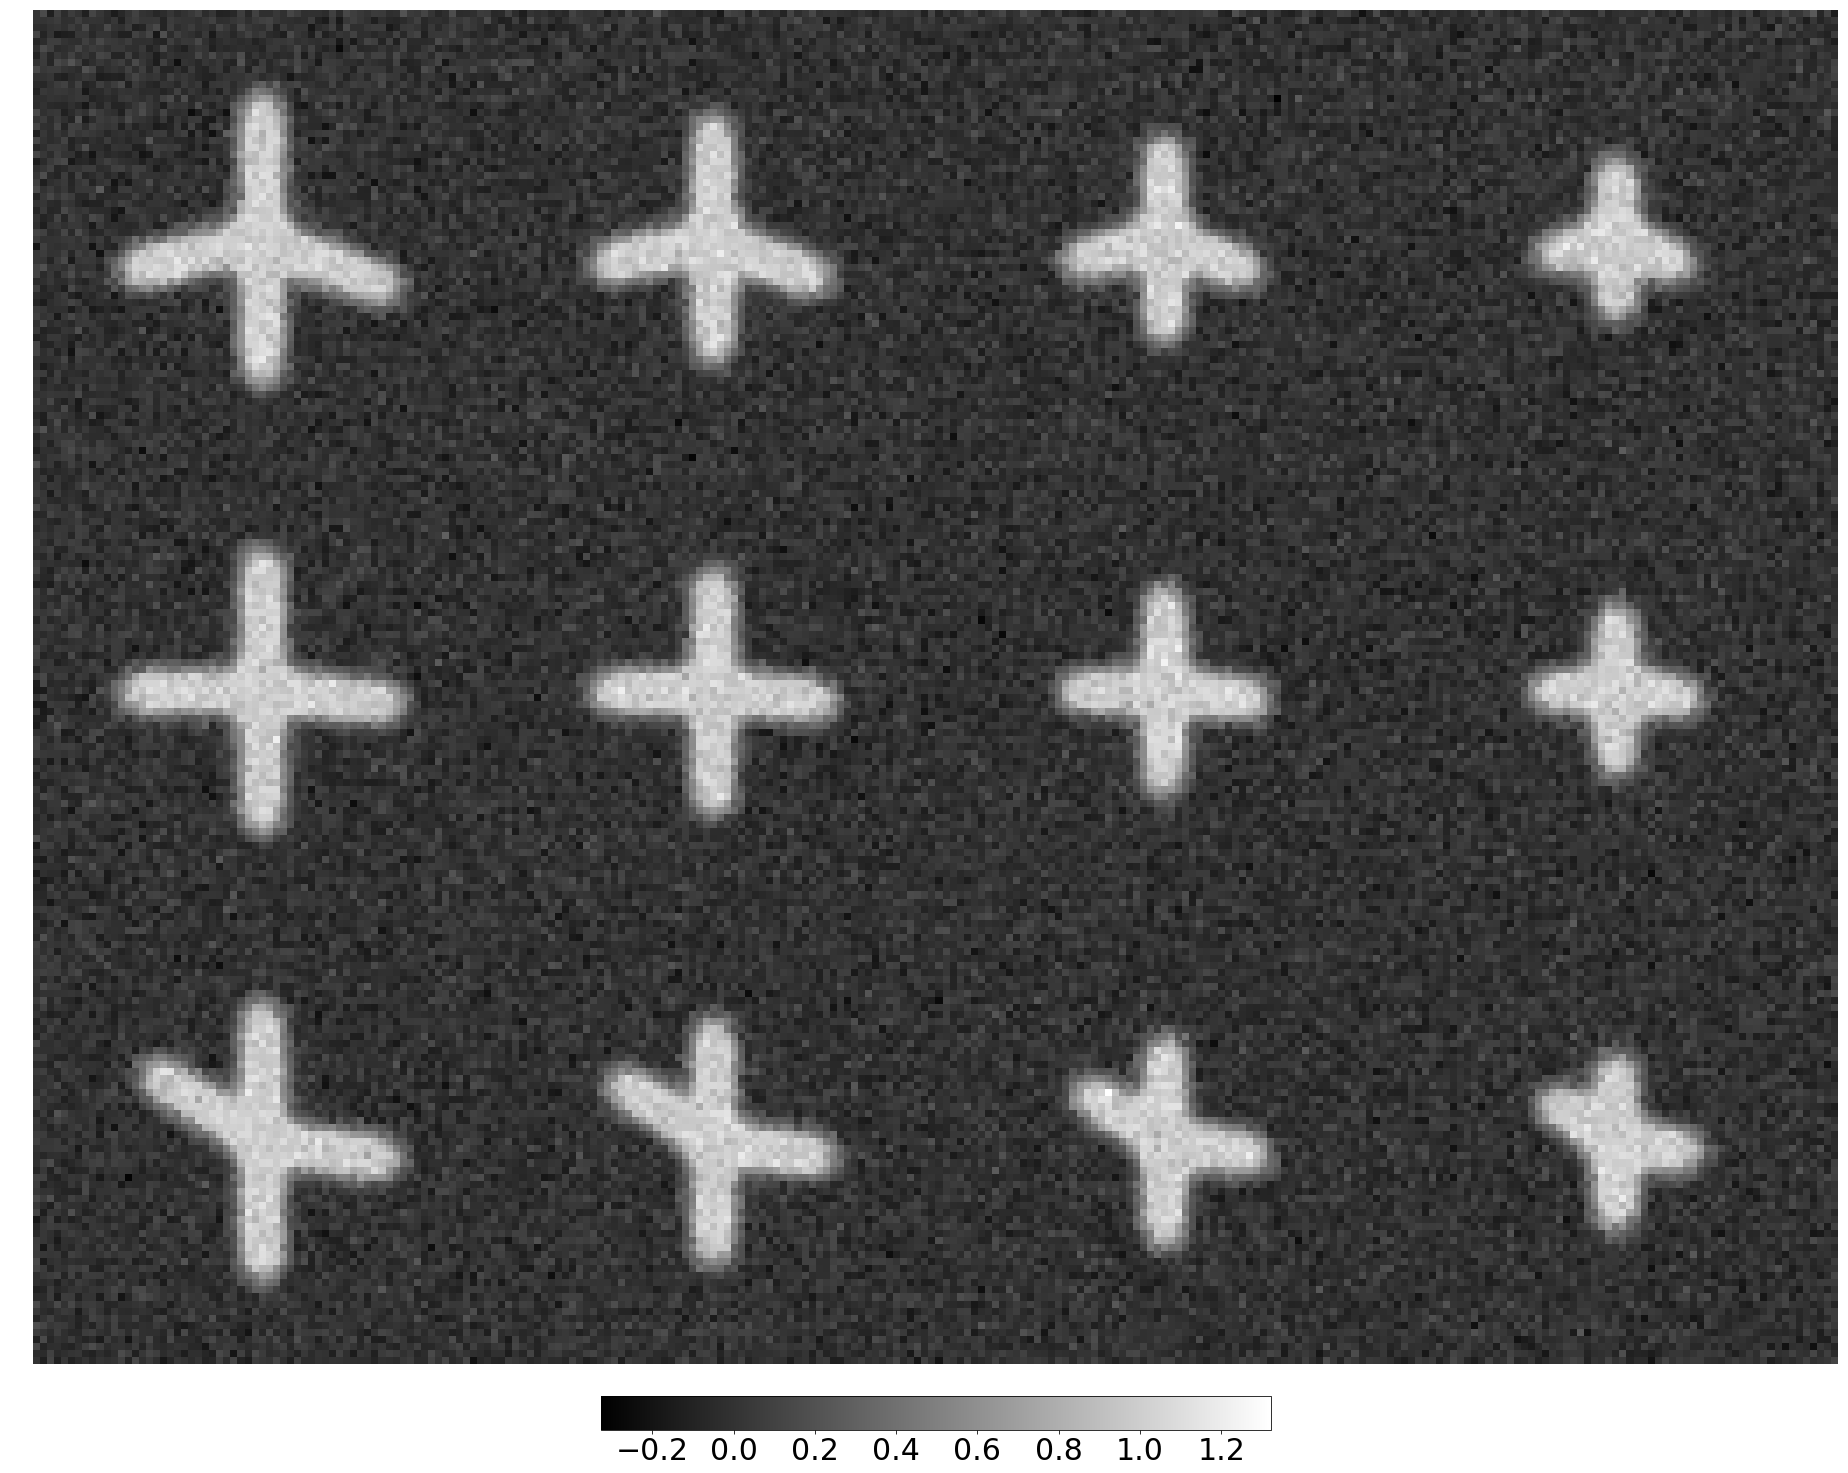

In [58]:
print('Examples of train registrations:')    
for i in range(1):
    targets = np.array(load_subject_images_from_data_set(i, xml_parameters_train))
    reconstructed = load_reconstructed_registration_train(i)
    print(np.min(targets), np.max(targets), np.min(reconstructed), np.max(reconstructed))
    residuals = np.array([targets[k] - reconstructed[k] for k in range(len(targets))])
    to_plot = []
    to_plot.append(targets)
    to_plot.append(reconstructed)
    to_plot.append(residuals)
    plot_images(to_plot, 'subject_'+str(i)+'.pdf')
    #plt.plot(np.sum(np.sum(residuals**2, axis=2), axis=1)/np.sum(np.sum(targets**2, axis=2), axis=1))
    #plt.show()
    
print('Examples of test registrations:')
to_plot = []
for i in range(3):
    targets = np.array(load_subject_images_from_data_set(i, xml_parameters_test))
    reconstructed = load_reconstructed_registration_test(i)
    #plt.hist(targets[0].flatten(), bins=20)
    #plt.show()
    #plt.hist(reconstructed[0].flatten(), bins=20)
    #plt.show()
    print(np.min(targets), np.max(targets), np.min(reconstructed), np.max(reconstructed))
    residuals = np.array([targets[k] - reconstructed[k] for k in range(len(targets))])
    
    to_plot.append([targets[0], targets[2], targets[4], targets[6]])
    #to_plot.append(reconstructed)
    #to_plot.append(residuals)
plot_images(to_plot, 'subject_'+str(i)+'.pdf')
    #plt.plot(np.sum(np.sum(residuals**2, axis=2), axis=1)/np.sum(np.sum(targets**2, axis=2), axis=1))
    #plt.show()
    


In [ ]:
#0.025
Train residuals 0.0420960585599 +/- 0.00429942762639
Train residuals (no noise) 0.0322673111137 +/- 0.00526740924893
Train residuals 0.0437429246338 +/- 0.00684108895367
Train residuals (no noise) 0.0341670541052 +/- 0.0079140123385

#0.05
Train residuals 0.0611469371355 +/- 0.00250973060539
Train residuals (no noise) 0.0318195153393 +/- 0.00371597779453
Train residuals 0.0621955290522 +/- 0.00312156845851
Train residuals (no noise) 0.0333124977898 +/- 0.00462457144818

#0.075
Train residuals 0.0845992551447 +/- 0.00357174326497
Train residuals (no noise) 0.0340663140275 +/- 0.00625220664957
Train residuals 0.0863481843086 +/- 0.00423800768489
Train residuals (no noise) 0.0368325530159 +/- 0.00652108795905

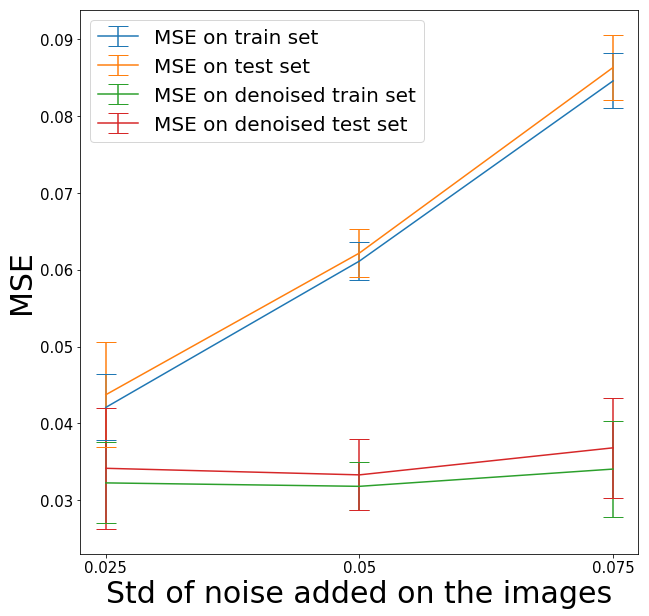

In [25]:
train_residuals = [0.0420960585599, 0.0611469371355, 0.0845992551447]
train_residuals_std = [0.00429942762639, 0.00250973060539, 0.00357174326497]
test_residuals = [0.0437429246338, 0.0621955290522, 0.0863481843086]
test_residuals_std = [0.00684108895367, 0.00312156845851 , 0.00423800768489]
train_residuals_no_noise = [0.0322673111137,  0.0318195153393, 0.0340663140275]
train_residuals_no_noise_std = [0.00526740924893, 0.00312156845851, 0.00625220664957]
test_residuals_no_noise = [0.0341670541052, 0.0333124977898, 0.0368325530159]
test_residuals_no_noise_std = [0.0079140123385, 0.00462457144818, 0.00652108795905]
ground_truth_noise = [0.025, 0.05, 0.075]

plt.figure(figsize=(10,10))
plt.errorbar(ground_truth_noise, train_residuals, train_residuals_std, label='MSE on train set', capsize=10)
plt.errorbar(ground_truth_noise, test_residuals, test_residuals_std, label='MSE on test set', capsize=10)
plt.errorbar(ground_truth_noise, train_residuals_no_noise, train_residuals_no_noise_std, label='MSE on denoised train set', capsize=10)
plt.errorbar(ground_truth_noise, test_residuals_no_noise, test_residuals_no_noise_std, label='MSE on denoised test set', capsize=10)
plt.xlabel('Std of noise added on the images', fontsize=30)
plt.ylabel('MSE', fontsize=30)
plt.xticks([0.025, 0.05, 0.075], ['0.025', '0.05', '0.075'])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})
plt.savefig(os.path.join('/Users/maxime.louis/Documents/metric_learning/synthetic_image/figures', 'MSE_train_test_with_without_noise.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

# MNIST PPCA Results



In [11]:
from sklearn.metrics import mean_squared_error

path_to_pca_mnist = '/Users/maxime.louis/Documents/metric_learning/pca_experiments/output_'
paths_to_pca_mnist = [path_to_pca_mnist + str(i) for i in range(2,20)]
path_to_pca_mnist_test = '/Users/maxime.louis/Documents/metric_learning/pca_experiments/test_output_'
paths_to_pca_mnist_test = [path_to_pca_mnist_test + str(i) for i in range(2,20)]
latent_space_dimensions = range(2,20)
mse_pca_train = []
mse_pca_test = []
for elt in paths_to_pca_mnist:
    mse_pca = np.loadtxt(os.path.join(elt, 'pca_reconstruction_error.txt'))
    mse_pca_train.append(mse_pca[0])
    mse_pca_test.append(mse_pca[1])
    
def img_number(im):
    return im[im.find('reconstructed_') + len('reconstructed_'):im.find('.npy')]
    
def target_number(im):
        return im[im.find('target_') + len('target_'):im.find('.npy')]

mse_train = []
mse_test = []
for i in range(len(paths_to_pca_mnist)):
    output_dir = paths_to_pca_mnist[i]
    test_output_dir = paths_to_pca_mnist_test[i]
    reconstructed = sorted([im for im in os.listdir(output_dir) if im.find('reconstructed_') >= 0], key=img_number)
    targets = sorted([im for im in os.listdir(output_dir) if im.find('target_') >= 0], key=target_number)
    reconstructed = [img.flatten() for img in load_images([os.path.join(output_dir, im) for im in reconstructed])]
    targets = [img.flatten() for img in load_images([os.path.join(output_dir, im) for im in targets])]
    assert len(reconstructed) == len(targets)
    mse_train.append(mean_squared_error(reconstructed, targets))
    
    reconstructed = sorted([im for im in os.listdir(test_output_dir) if im.find('reconstructed_') >= 0], key=img_number)
    targets = sorted([im for im in os.listdir(test_output_dir) if im.find('target_') >= 0], key=target_number)
    reconstructed = [img.flatten() for img in load_images([os.path.join(test_output_dir, im) for im in reconstructed])]
    targets = [img.flatten() for img in load_images([os.path.join(test_output_dir, im) for im in targets])]
    assert len(reconstructed) == len(targets)
    mse_test.append(mean_squared_error(reconstructed, targets))
    
    #print(output_dir, test_output_dir, mse_train[-1], mse_test[-1])

    
#alternative:
for i in range(len(paths_to_pca_mnist)):
    output_dir = paths_to_pca_mnist[i]
    test_output_dir = paths_to_pca_mnist_test[i]
    residuals_train = np.loadtxt(os.path.join(output_dir, 'residuals.txt'))/(28*28)
    residuals_test = np.loadtxt(os.path.join(test_output_dir, 'residuals.txt'))/(28*28)
    #print(output_dir, test_output_dir, np.mean(residuals_train), np.mean(residuals_test))


KeyboardInterrupt: 

In [15]:
plt.figure(figsize=(10,10))
plt.plot(latent_space_dimensions, mse_test, label='MSE on test set')
plt.plot(latent_space_dimensions, mse_train, label='MSE on train set')
plt.plot(latent_space_dimensions, mse_pca_test, label='MSE with PCA on test set')
plt.plot(latent_space_dimensions, mse_pca_train, label='MSE with PCA on train set')
plt.legend(prop={'size': 25})
plt.xticks(latent_space_dimensions, [str(e) for e in latent_space_dimensions])
plt.xlabel('Latent space dimension', fontsize=30)
plt.ylabel('Mean Squared Error', fontsize=30)
plt.savefig(os.path.join('/Users/maxime.louis/Documents/metric_learning/synthetic_image/figures', 'pca_fit.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (18,) and (1,)

The nn has 4505 weights.
4505


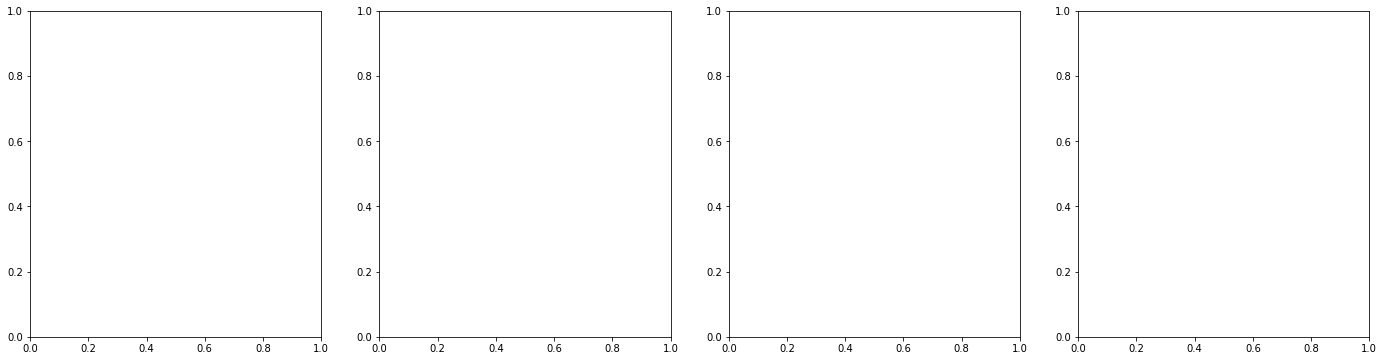

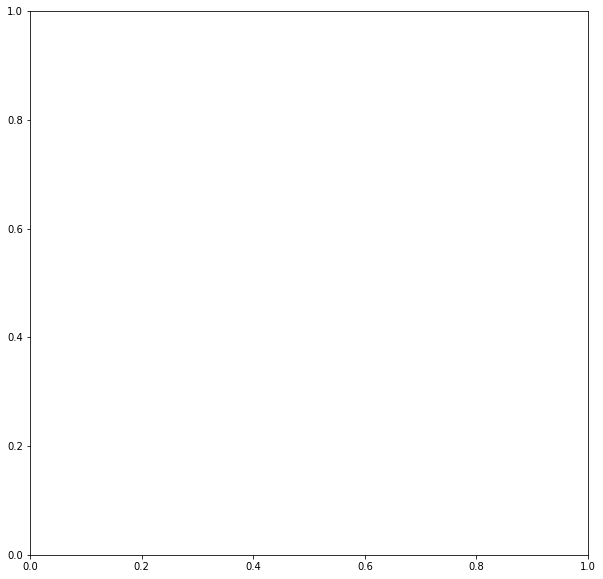

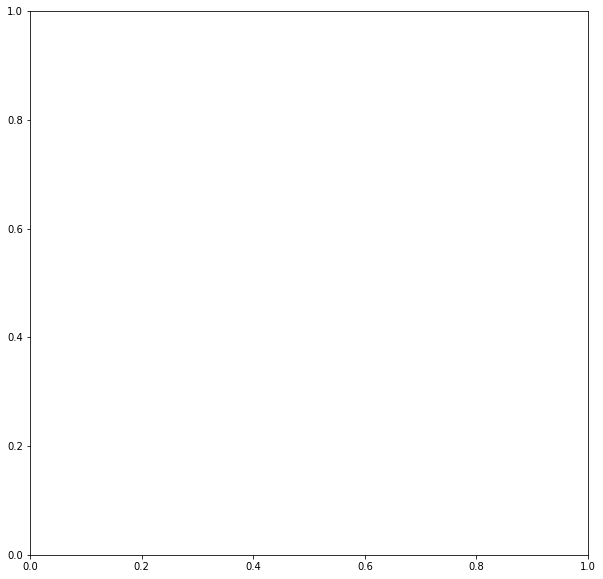

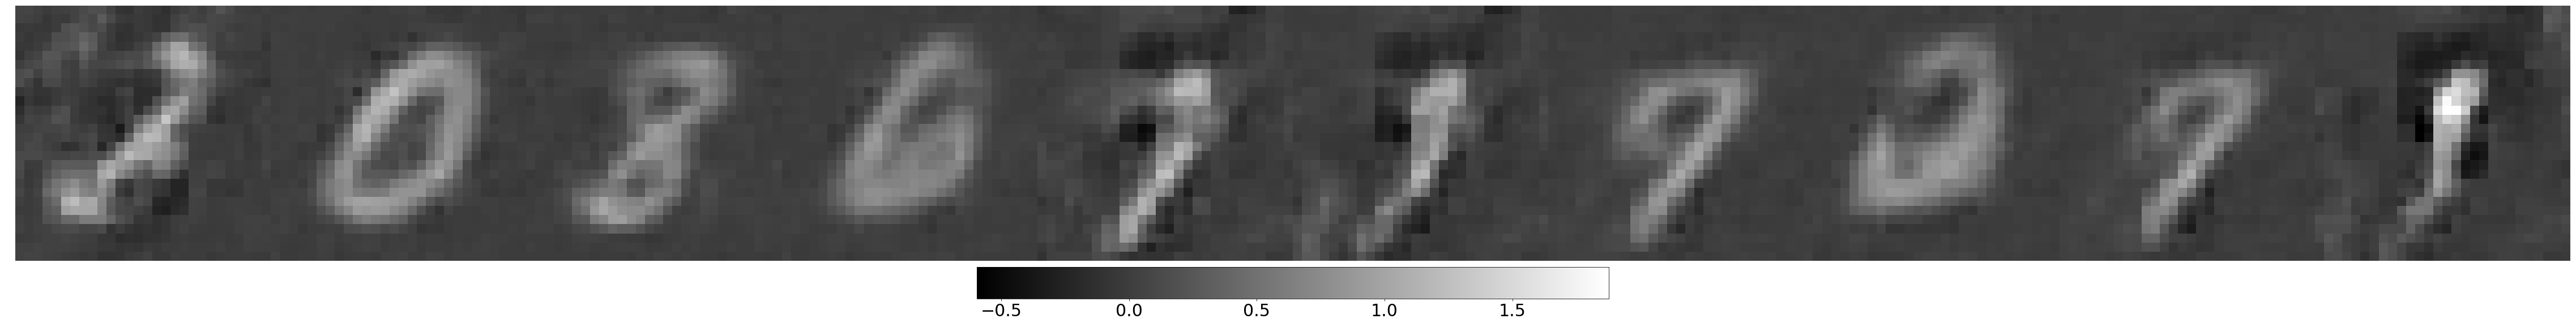

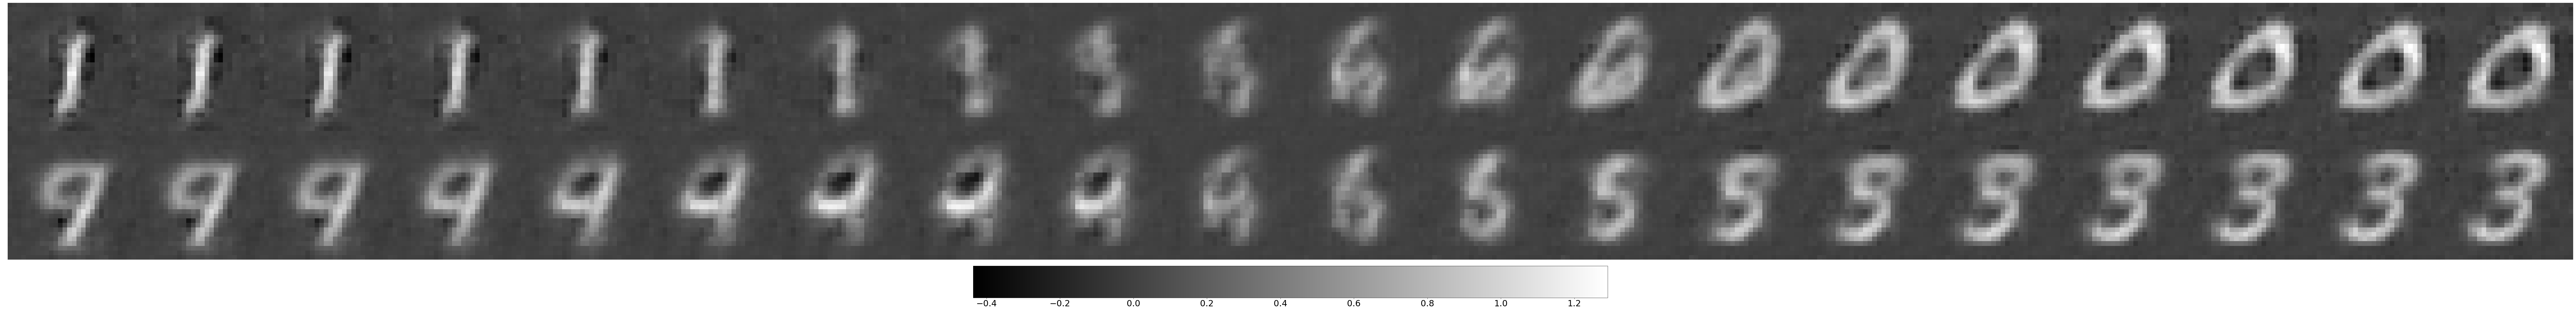

The nn has 4537 weights.
4537


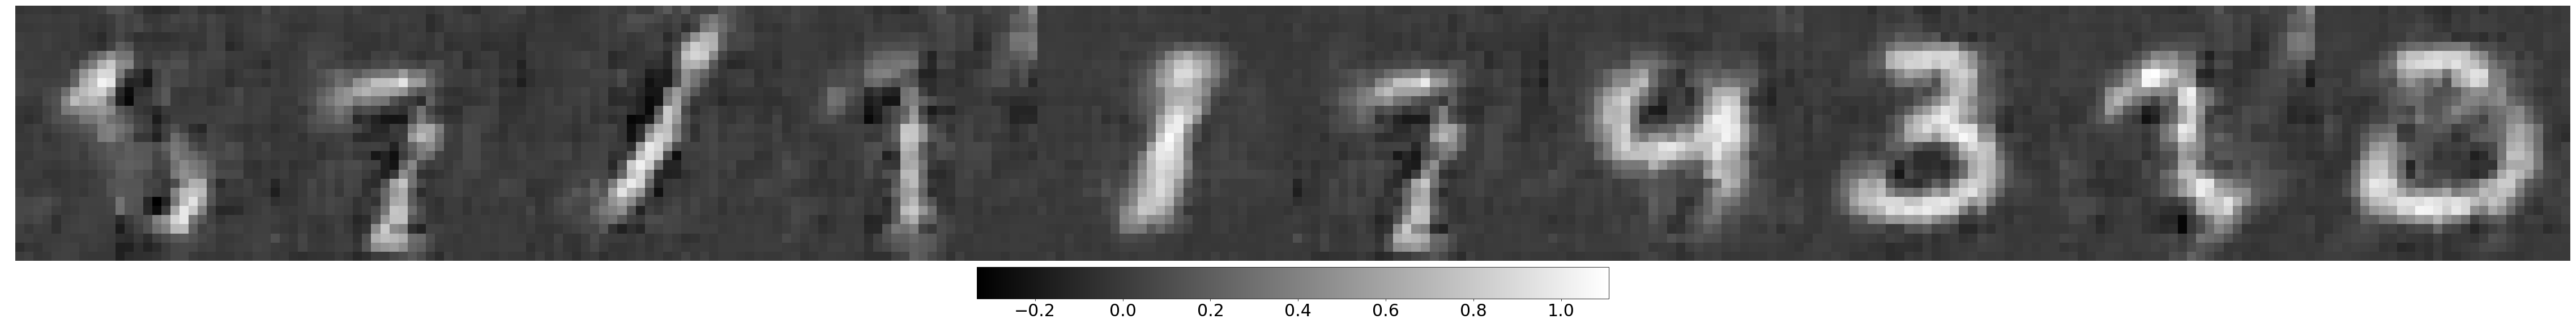

KeyboardInterrupt: 

In [16]:
# We build a tool to generate any image with given coordinates
from pydeformetrica.src.core.model_tools.manifolds.metric_learning_nets import MnistNet

lsds = range(2,20)
for number in range(len(lsds)):
    net = MnistNet(in_dimension=lsds[number])
    print(len(net.get_parameters()))
    nn_parameters = Variable(torch.from_numpy(np.loadtxt(os.path.join(paths_to_pca_mnist[number], 'DeepPgaModel_metric_parameters.txt'))))
    net.set_parameters(nn_parameters)

    def get_image(position):
        latent_space_position_torch = Variable(torch.from_numpy(position))
        out_torch = net(latent_space_position_torch)
        out_np = out_torch.data.numpy()
        return out_np

    images = []
    for i in range(10):
        position = np.random.normal(0, 3, size=((lsds[number],)))
        images.append(get_image(position))
    plot_images(images)
        
    images = []
    for i in range(lsds[number]):
        direction = np.zeros((lsds[number],))
        direction[i] = 3.
        positions = [direction * t for t in np.linspace(-1, 1, 20)]
        ims = [get_image(elt) for elt in positions]
        images.append(ims)

    plot_images(images, name='pca_' + str(lsds[number]) + '.pdf')




(800, 2)


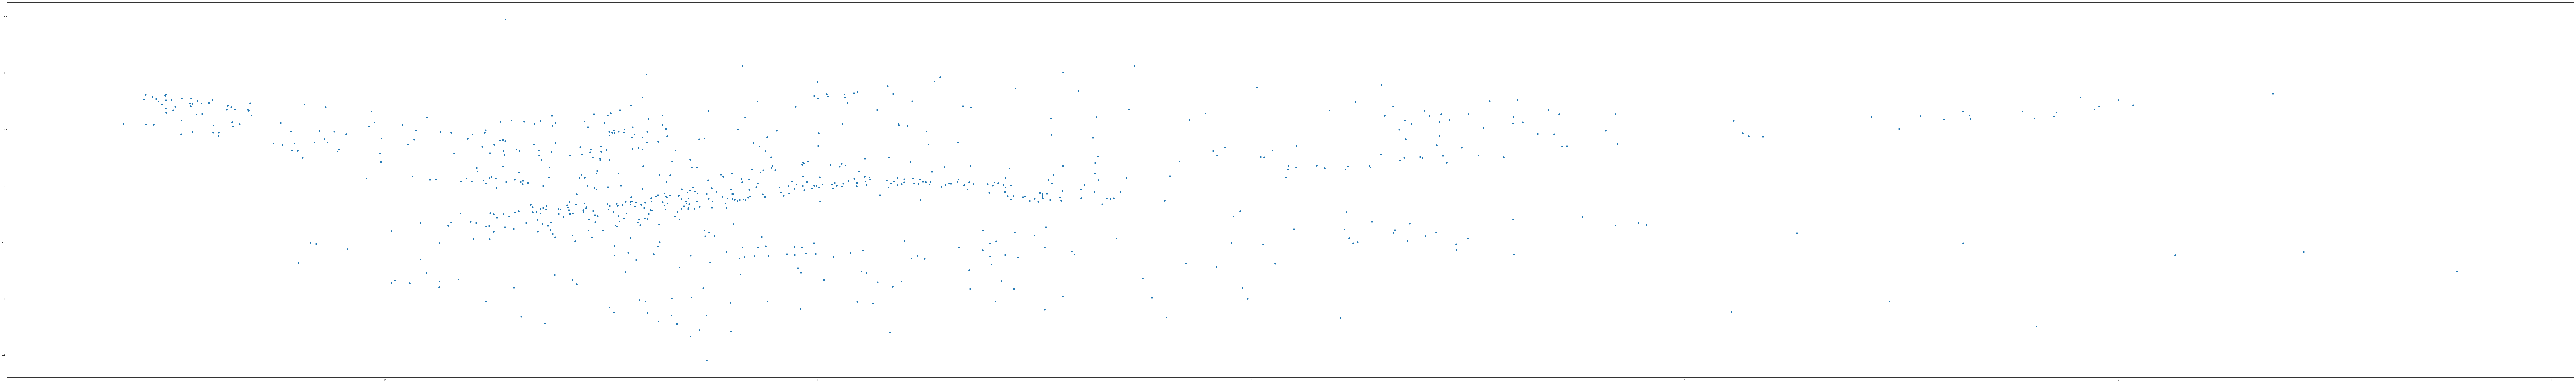

(800, 3)


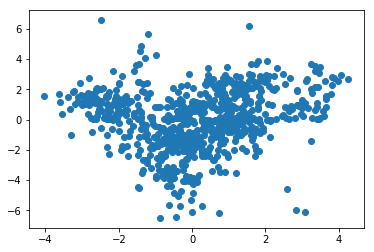

KeyboardInterrupt: 

In [17]:
# Looking at the latent space positions
for elt in paths_to_pca_mnist:
    latent_space_positions = np.loadtxt(os.path.join(elt, 'DeepPgaModel_latent_position.txt'))
    print(latent_space_positions.shape)
    plt.scatter(latent_space_positions[:, 0], latent_space_positions[:, 1])
    plt.show()

/Users/maxime.louis/Documents/metric_learning/pca_experiments/output_10
(800,)


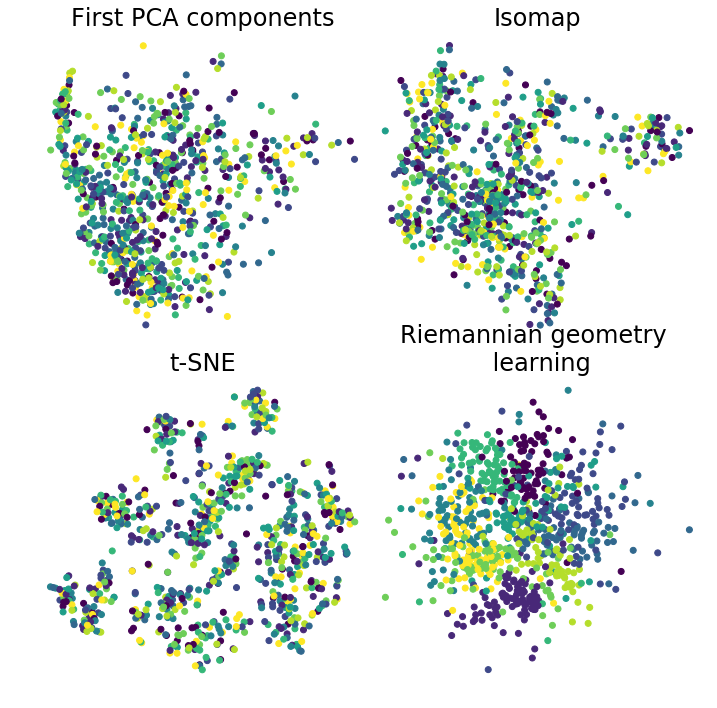

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
import matplotlib.pyplot as plt
import matplotlib
# 3 alternatives:
# represent the 2 first pca directions
# represent the result of isomap
# show the resuld with the infered metric (mds)
f, axarr = plt.subplots(2, 2, figsize=(12, 12))
i = 8
output_dir = paths_to_pca_mnist[i]
print(output_dir)
train_labels = np.loadtxt(os.path.join(output_dir, 'labels_train.txt'), dtype=float)
print(train_labels.shape)
data = sorted([os.path.join(output_dir, im) for im in os.listdir(output_dir) if im.find('target_') >= 0], key=target_number)
data = load_images(data)

pca = PCA(n_components=2)
latent_space_positions = pca.fit_transform([elt.flatten() for elt in data])
axarr[0,0].scatter(latent_space_positions[:,0], latent_space_positions[:,1], c=train_labels)
axarr[0,0].set_title('First PCA components', fontsize=24)
axarr[0,0].axis('off')

isomap = Isomap(n_components=2)
latent_space_positions = isomap.fit_transform([elt.flatten() for elt in data])
axarr[0,1].scatter(latent_space_positions[:,0], latent_space_positions[:,1], c=train_labels)
axarr[0,1].set_title('Isomap', fontsize=24)
axarr[0,1].axis('off')

tsne = TSNE(n_components=2)
latent_space_positions = tsne.fit_transform([elt.flatten() for elt in data])
axarr[1,0].scatter(latent_space_positions[:,0], latent_space_positions[:,1], c=train_labels)
axarr[1,0].set_title('t-SNE', fontsize=24)
axarr[1,0].axis('off')

positions = np.loadtxt(os.path.join(output_dir, 'DeepPgaModel_latent_position.txt'))
mds = MDS(n_components=2)
p = mds.fit_transform(positions)
axarr[1,1].scatter(p[:,0], p[:,1], c=train_labels)
axarr[1,1].set_title('Riemannian geometry \n learning', fontsize=24)
#plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
axarr[1,1].axis('off')

plt.subplots_adjust(wspace=0., hspace=0.12)

plt.savefig(os.path.join('/Users/maxime.louis/Documents/metric_learning/synthetic_image/figures','pca_analysis.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()